# Attention analysis

## loading multiple attention files

In [1]:
from glob import glob
import os

bases = glob('outputs/mistral7b*')
# bases += glob('outputs/exp2*')
# bases += glob('outputs/exp3*')

exp_files = [glob(os.path.join(b, '*_attentions.pkl')) for b in bases]
print([(b, len(e)) for b, e in zip(bases, exp_files)])

json_files = [[p.replace('_attentions.pkl', '.json') for p in files] for files in exp_files]

exp_files[-1][:3], json_files[-1][:3]

[('outputs/mistral7b_c1_hl_partial', 25), ('outputs/mistral7b_c5_hf_partial', 25), ('outputs/mistral7b_c5_hl_partial', 25), ('outputs/mistral7b_c1_hf_partial', 25), ('outputs/mistral7b_c3_hf_partial', 25), ('outputs/mistral7b_c3_hl_partial', 25), ('outputs/mistral7b_full', 26)]


(['outputs/mistral7b_full/7195_attentions.pkl',
  'outputs/mistral7b_full/2666_attentions.pkl',
  'outputs/mistral7b_full/600_attentions.pkl'],
 ['outputs/mistral7b_full/7195.json',
  'outputs/mistral7b_full/2666.json',
  'outputs/mistral7b_full/600.json'])

## getting attention on strategy tokens

In [2]:
from analyze_attention_weights import get_average_attention_over_sequence
import pickle
from transformers import AutoTokenizer
from tqdm import tqdm
from typing import Dict, List

# tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-70b-chat-hf')
tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.2')

def get_attention_per_strategy(files, exp_name) -> List[Dict]:
    data = []
    filtered_files = []
    for file in files:
        try:
            with open(file, 'rb') as f:
                data.append(pickle.load(f))
                filtered_files.append(file)
        except Exception as e:
            print(f"couldn't load {file}.")
            raise e

    res = []
    for example, p in tqdm(zip(data, filtered_files)):
        if example is None:
            continue
        for strategy, (tokens, attentions) in example.items():
            strategy_str = f'"{strategy}"'
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=strategy_str, tokenizer=tokenizer)
            res.append({
                'strategy': strategy,
                'strategy_attn': attn,
                'method': exp_name,
                'path': p
            })
            
    return res



attns = [get_attention_per_strategy(files, exp_name) for files, exp_name in zip(exp_files, [b.split('/')[-1] for b in bases])]
    

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

25it [00:00, 349.75it/s]
25it [00:00, 437.99it/s]
25it [00:00, 426.40it/s]
25it [00:00, 503.78it/s]
25it [00:00, 441.22it/s]
25it [00:00, 395.41it/s]
26it [00:00, 428.75it/s]


## visualize sra for different model sizes

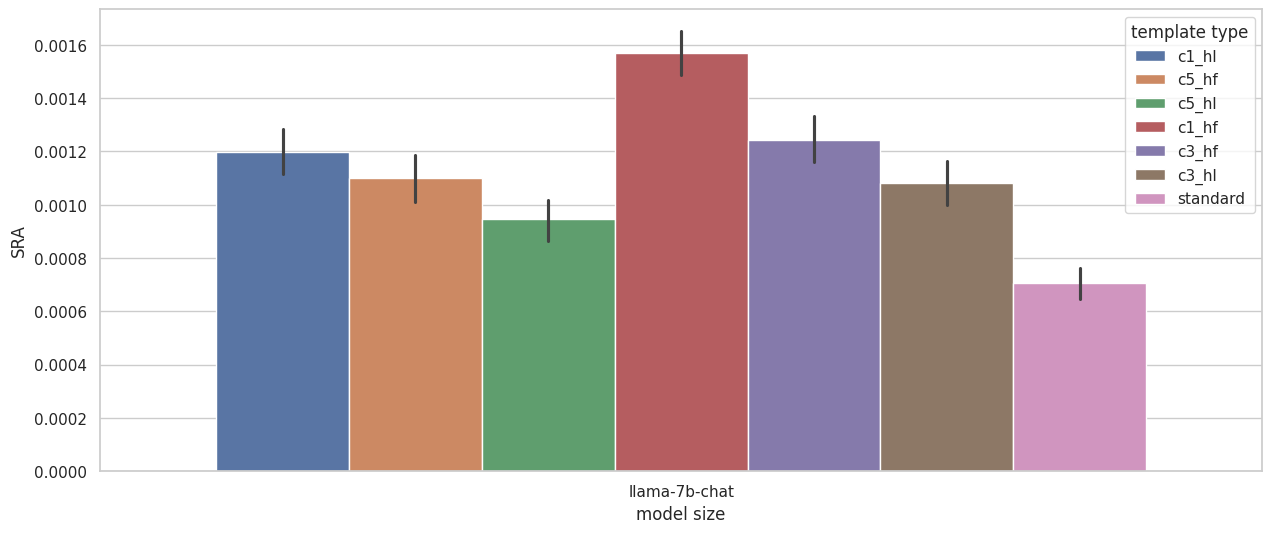

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

all_attns = [a for attn in attns for a in attn]

df = pd.DataFrame(all_attns)

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['method'].apply(add_template_type)
df['model size'] = df['method'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='strategy_attn', hue='template type')
plt.ylabel('SRA')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


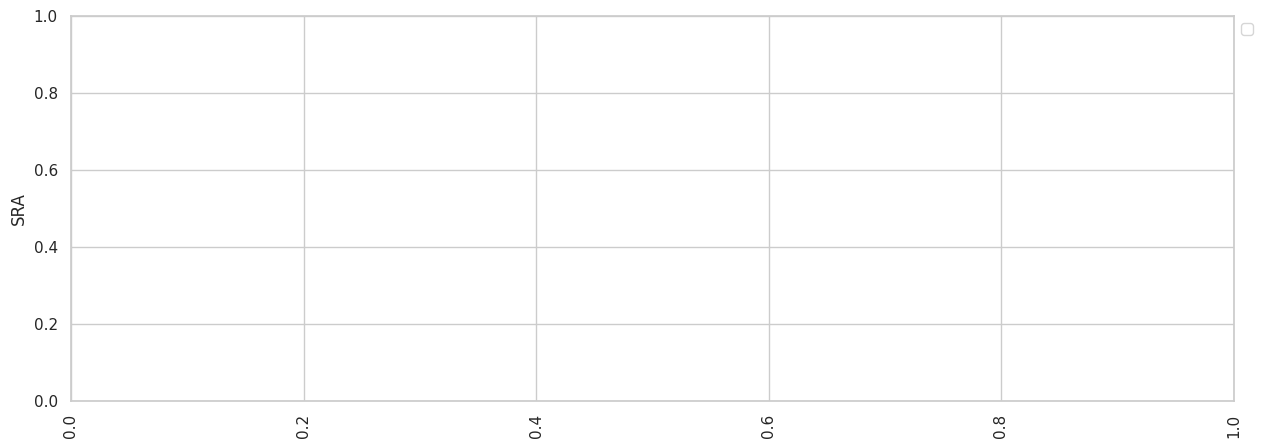

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd

all_attns = [a for attn in attns for a in attn]
df = pd.DataFrame(all_attns)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
df['template type'] = df['method'].apply(add_template_type)
sns.barplot(df[df['method'].str.contains('exp1')], x='strategy', y='strategy_attn', hue='template type')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('SRA')
plt.show()


## measuring attention vs number of utterances in history

### get length of inputs per attention outputs

In [5]:
import json 

attn_lens = []
all_attns = [a for attn in attns for a in attn]

for example in tqdm(all_attns):
    json_path = example['path'].replace('_attentions.pkl', '.json')
    
    with open(json_path, 'r') as f:
        json_d = json.load(f)
    n_turns = len(json_d['dialog'])
    d = example.copy()
    d['n_turns'] = n_turns
    attn_lens.append(d)

attn_lens[-1]

df = pd.DataFrame(attn_lens)
df['template type'] = df['method'].apply(add_template_type)
df['model name'] = df['method'].apply(add_model_size)

100%|█████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 9879.25it/s]


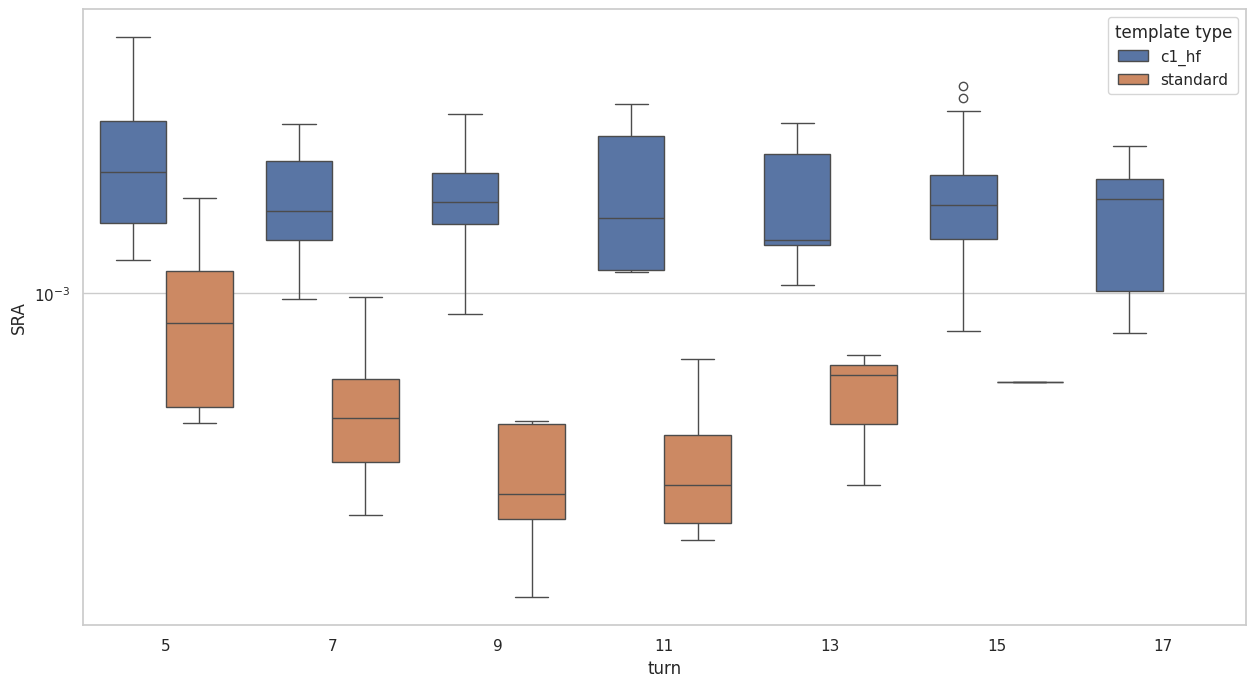

In [6]:

import matplotlib.pyplot as plt
df['template type'] = df['method'].apply(add_template_type)
df['model size'] = df['method'].apply(add_model_size)

plt.figure(figsize=(15,8))
sns.boxplot(df[(df['template type'] == 'c1_hf') | (df['template type'] == 'standard')], x='n_turns', y='strategy_attn', hue='template type')
plt.yscale('log')
plt.ylabel('SRA')
plt.xlabel('turn')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


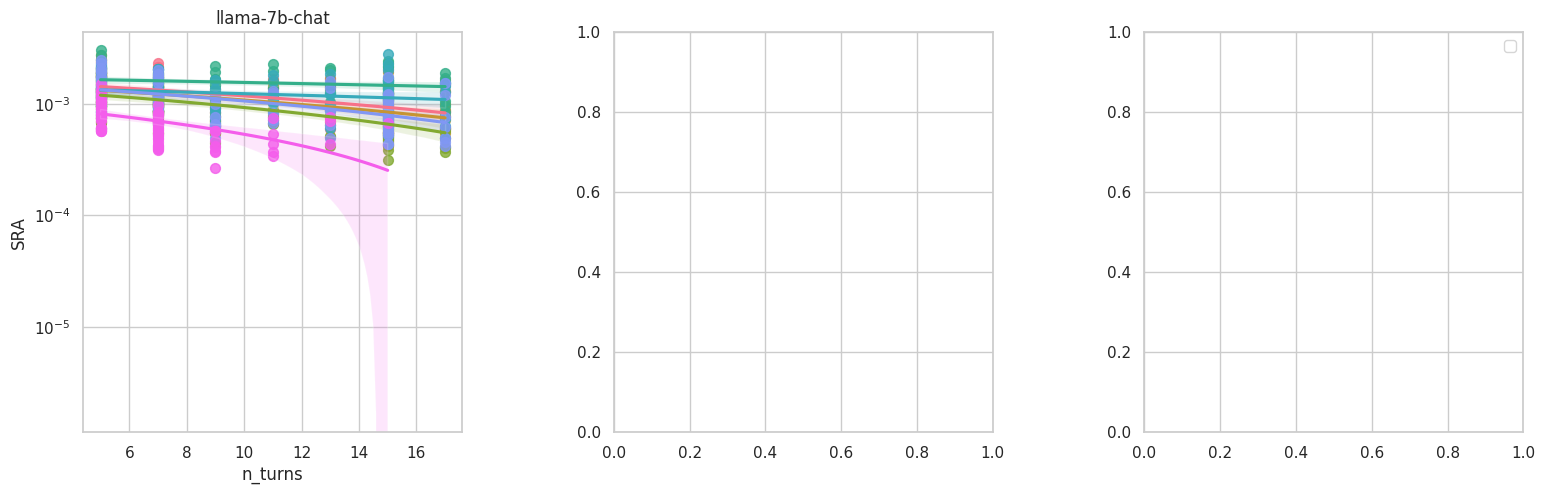

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Color palette
template_types = list(df['template type'].unique())
palette = sns.color_palette('husl', len(template_types))

model_names = list(df['model name'].unique())
for ax, model_name in zip(axs, model_names):
    cur_df = df[df['model name'] == model_name]
    ax.set_title(model_name)
    # Iterate over each group to plot
    for i, group in enumerate(template_types):
        subset = cur_df[cur_df['template type'] == group]
        sns.regplot(x='n_turns', y='strategy_attn', data=subset, ax=ax, label=group, color=palette[i], scatter_kws={'s': 50})
    ax.set_ylabel('SRA')
    ax.set_yscale('log')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.legend()
plt.show()


# measuring predictability of responses for each prompting scheme

## loading datasets

In [ ]:
import json
from glob import glob
import os

bases = glob('outputs/exp1*')

exp_files = [glob(os.path.join(b, '*_attentions.pkl')) for b in bases]
json_files = [[p.replace('_attentions.pkl', '.json') for p in files] for files in exp_files]


def load_dataset(files):
    ds = []
    for p in files:
        with open(p, 'r') as f:
            d = json.load(f)
            ds.append(d)
    return ds

datasets = [load_dataset(fs) for fs in json_files]

for ds in datasets:
    print("size of ds: ", len(ds))

## convert to seq classification dataset

In [ ]:
def to_seq_classification_ds(ds):
    seqs = []
    labels = []
    turns = []
    wrong_format = 0
    total = 0
    
    for d in ds:
        if d is None:
            print("Ran into empty json")
            continue
        for strategy, resp in d['responses'].items():
            seq_txt = resp.lower()
            if 'assistant: ' not in seq_txt:
                wrong_format += 1
                seq_txt = 'assistant: ' + seq_txt
            
            assert 'assistant: ' in seq_txt, seq_txt

            seq_txt = seq_txt.split('assistant: ')[-1]

            #remove mentions of the strategy in text
            seq_txt = seq_txt.replace(strategy.lower(), "")
            seqs.append(seq_txt)
            labels.append(strategy)
            turns.append(len(d['dialog']))
            total += 1

    print(f"{wrong_format}/{total} had wrong format")
    return seqs, labels, turns

datasets_xy = [to_seq_classification_ds(d) for d in datasets]

In [ ]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def train_and_report(ds_x, ds_y):
    vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))
    X = vectorizer.fit_transform(ds_x)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(ds_y)

    X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)
    
    model = LogisticRegressionCV(max_iter=200, cv=4)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('accuracy: ', acc)
    return acc


names = [b.split('/')[-1] for b in bases]
accs = []
for name, ds in zip(names, datasets_xy):
    print(name)
    accs.append(train_and_report(ds[0], ds[1]))
    

## Save accuracy results

In [ ]:
import pickle

# with open('pred_acc_7b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

# with open('pred_acc_13b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

with open('pred_acc_70b.pkl', 'wb') as f:
    pickle.dump((names, accs), f)


## combine results and visualize

In [ ]:
import pickle

with open('pred_acc_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b



In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='accuracy', hue='template type')
plt.ylabel('Accuracy')

plt.show()


## classifier on semantic embeddings

### load embeddings

In [ ]:
dataset_paths = glob('outputs/exp1*/response_encodings.pkl')


datasets_xy = []
for p in dataset_paths:
    with open(p, 'rb') as f:
        ds = pickle.load(f)
        print(len(ds[0]))
        datasets_xy.append(ds)



In [ ]:
import re

names = [re.findall('exp\d+_(.+)/', x)[0] for x in dataset_paths]
names

In [ ]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder


def train_and_report(ds_x, ds_y):

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(ds_y)

    X_train, X_test, y_train, y_test = train_test_split(ds_x, encoded_labels, test_size=0.2)
    
    model = LogisticRegressionCV(max_iter=200, cv=4)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('accuracy: ', acc)
    return acc


accs = []
for name, ds in zip(names, datasets_xy):
    print(name)
    accs.append(train_and_report(ds[0], ds[1]))
    

In [ ]:
import pickle

# with open('pred_acc_sbert_7b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

# with open('pred_acc_sbert_13b.pkl', 'wb') as f:
#     pickle.dump((names, accs), f)

with open('pred_acc_sbert_70b.pkl', 'wb') as f:
    pickle.dump((names, accs), f)


## combine results and visualize

In [ ]:
import pickle

with open('pred_acc_sbert_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_sbert_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_sbert_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b



In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)
plt.figure(figsize=(15,6))
sns.barplot(df, x='model size', y='accuracy', hue='template type')
plt.ylabel('Accuracy')

plt.show()


## combined plot for the paper

In [ ]:
import pickle

with open('pred_acc_sbert_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_sbert_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_sbert_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names = names_7b + names_13b + names_70b
accs = accs_7b + accs_13b + accs_70b
predictors = ['semantic features']*len(names)

with open('pred_acc_7b.pkl', 'rb') as f:
    names_7b, accs_7b = pickle.load(f)

with open('pred_acc_13b.pkl', 'rb') as f:
    names_13b, accs_13b = pickle.load(f)

with open('pred_acc_70b.pkl', 'rb') as f:
    names_70b, accs_70b = pickle.load(f)

names += (names_7b + names_13b + names_70b)
accs += (accs_7b + accs_13b + accs_70b)
predictors += ['lexical features']*len((names_7b + names_13b + names_70b))

len(names), len(accs), len(predictors)

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style='whitegrid') 

df = pd.DataFrame({'name': names, 'accuracy':accs, 'predictor': predictors})

import matplotlib.pyplot as plt

def add_template_type(value):
    if 'full' in value:
        return 'standard'
    elif 'c1_hf' in value:
        return 'c1_hf'
    elif 'c3_hf' in value:
        return 'c3_hf'
    elif 'c5_hf' in value:
        return 'c5_hf'
    elif 'c1_hl' in value:
        return 'c1_hl'
    elif 'c3_hl' in value:
        return 'c3_hl'
    elif 'c5_hl' in value:
        return 'c5_hl'
    else:
        print(value)
        raise Exception()

def add_model_size(value):
    if '7b' in value:
        return 'llama-7b-chat'
    elif '13b' in value:
        return 'llama-13b-chat'
    elif '70b' in value:
        return 'llama-70b-chat'
    else:
        print(value)
        raise Exception()


df['template type'] = df['name'].apply(add_template_type)
df['model size'] = df['name'].apply(add_model_size)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=df[df['predictor']=='lexical features'], x='model size', y='accuracy', hue='template type', ax=axes[0])
axes[0].set_title('LR on lexical features')

sns.barplot(data=df[df['predictor']=='semantic features'], x='model size', y='accuracy', hue='template type', ax=axes[1])
axes[1].set_title('LR on semantic features')

plt.tight_layout()

plt.show()

## analyzing LR coefficients

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=english_stopwords, lowercase=True, max_df=0.9, ngram_range=(2, 3))

ds_x, ds_y = datasets_xy[0][0], datasets_xy[0][1]

X = vectorizer.fit_transform(ds_x)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(ds_y)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2)

model = LogisticRegressionCV(max_iter=300, cv=4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('accuracy: ', acc)

In [ ]:
for i in range(15):
    coefficients = model.coef_[i]
    strategy = label_encoder.inverse_transform([i])[0]
    
    # Step 4: Map coefficients to words
    feature_names = vectorizer.get_feature_names_out()
    word_coefficient_tuples = list(zip(feature_names, coefficients))
    
    # Step 5: Sort and display
    sorted_word_coefficients = sorted(word_coefficient_tuples, key=lambda x: x[1], reverse=True)
    print("*"*100)
    print("strategy: ", strategy)
    print("*"*100)
    for word, score in sorted_word_coefficients[:10]:
        print(f"{word} -> {score}")